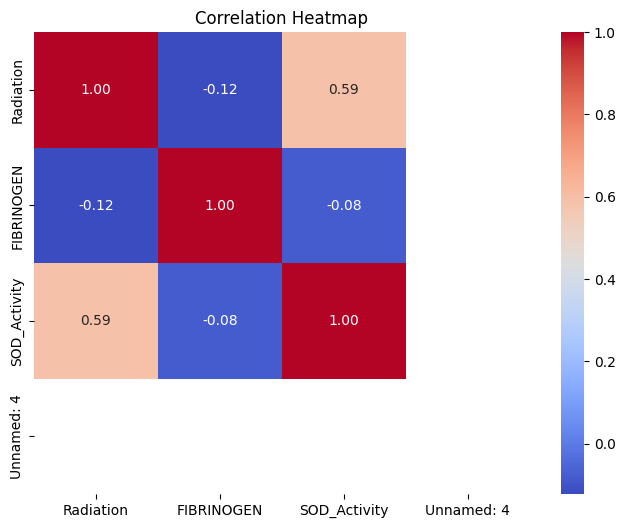

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Model Performance for SOD Prediction:
Mean Absolute Error (MAE): 0.9994
Mean Squared Error (MSE): 1.5829
Root Mean Squared Error (RMSE): 1.2581
r2 score): -0.0748


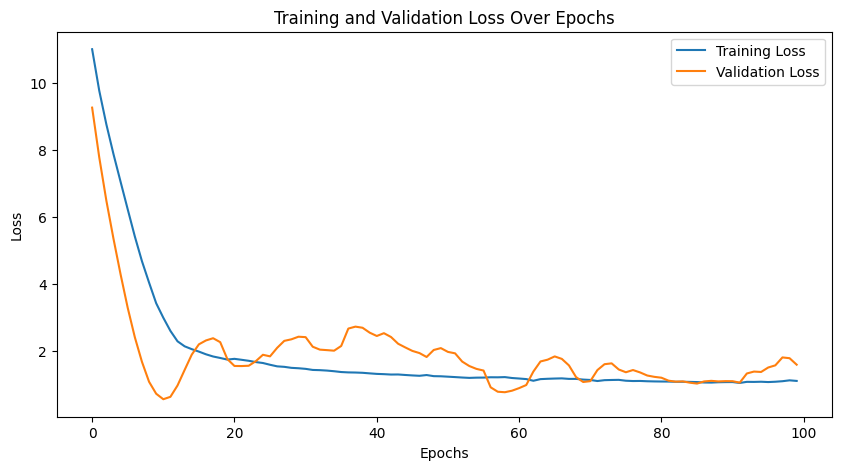

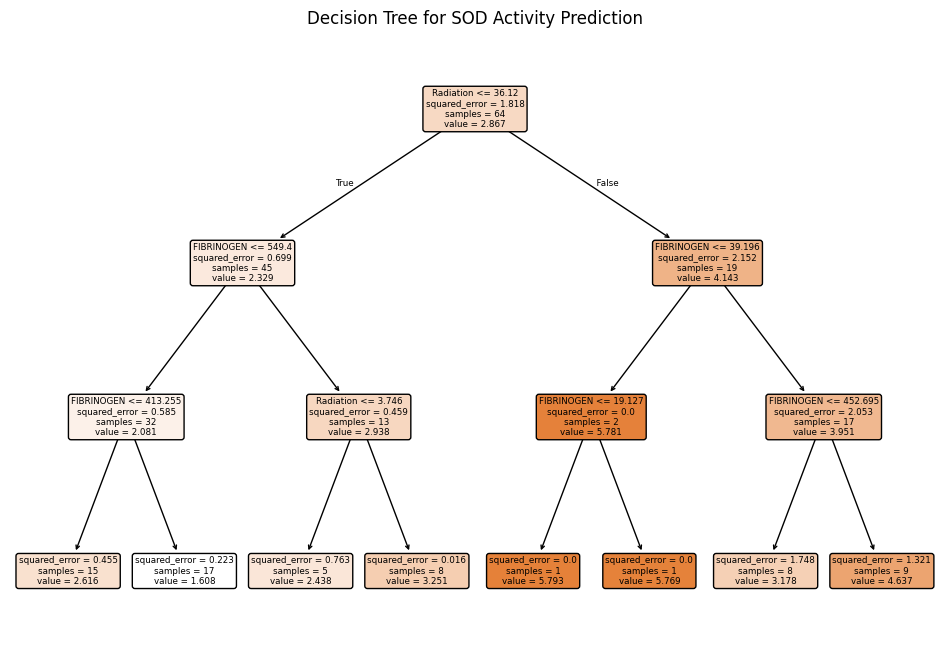


Classification Report:
                                 precision    recall  f1-score   support

Not Exposed to Oxidative Stress       1.00      0.82      0.90        11
    Exposed to Oxidative Stress       0.50      1.00      0.67         2

                       accuracy                           0.85        13
                      macro avg       0.75      0.91      0.78        13
                   weighted avg       0.92      0.85      0.86        13

Accuracy: 84.62%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(



Predicted SOD Activity: 2.90
Exposure Status: Not Exposed to Oxidative Stress
Threshold for Oxidative Stress (SOD): 3.5


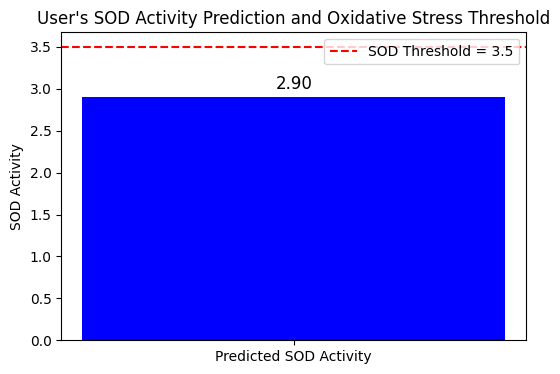

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Load dataset and handle missing data
file_path = 'os.csv'   # Update with the correct path to your CSV file
df = pd.read_csv(file_path)
df.replace("", np.nan, inplace=True)
df.dropna(subset=['SOD_Activity', 'FIBRINOGEN', 'Radiation'], inplace=True)

# Convert columns to float for analysis
df['Radiation'] = df['Radiation'].astype(float)
df['SOD_Activity'] = df['SOD_Activity'].astype(float)
df['FIBRINOGEN'] = df['FIBRINOGEN'].astype(float)

# Generate heatmap for correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = df.iloc[:, 1:].corr()  # Exclude the first column
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Prepare the input and target variables
X = df[['Radiation', 'FIBRINOGEN']]
y = df['SOD_Activity']

# Apply polynomial transformation for a more complex relationship
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance for SOD Prediction:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"r2 score): {r2:.4f}")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Decision Tree plotting
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_model, filled=True, feature_names=['Radiation', 'FIBRINOGEN'], rounded=True)
plt.title("Decision Tree for SOD Activity Prediction")
plt.show()

sod_threshold = 3.5

# Function to classify oxidative stress based on threshold
def classify_oxidative_stress_classification(y_true, y_pred, threshold=3.5):
    # Convert continuous values to binary classes (1: Exposed to Oxidative Stress, 0: Not Exposed)
    y_true_class = (y_true > threshold).astype(int)
    y_pred_class = (y_pred > threshold).astype(int)

    # Ensure both 0 and 1 are present in the classification
    labels = [0, 1]  # Ensure we specify the labels for both classes

    # Calculate accuracy
    accuracy = accuracy_score(y_true_class, y_pred_class)

    # Generate and print classification report with zero_division=1 to handle undefined metrics
    report = classification_report(y_true_class, y_pred_class, labels=labels,
                                  target_names=['Not Exposed to Oxidative Stress', 'Exposed to Oxidative Stress'],
                                  zero_division=1)

    return accuracy, report

# Generate the classification report and accuracy
accuracy, report = classify_oxidative_stress_classification(y_test, y_pred)

print("\nClassification Report:")
print(report)
print(f"Accuracy: {accuracy * 100:.3f}%")

# Function to classify oxidative stress based on user input
def classify_oxidative_stress(radiation, fibrinogen):
    # Prepare the input data with polynomial transformation and scaling
    input_data = np.array([[radiation, fibrinogen]])
    input_data_poly = poly.transform(input_data)
    input_data_scaled = scaler.transform(input_data_poly)
    predicted_sod = model.predict(input_data_scaled)[0][0]

    # Classify based on threshold
    status = "Exposed to Oxidative Stress" if predicted_sod > sod_threshold else "Not Exposed to Oxidative Stress"
    return predicted_sod, status

# Get user input for Radiation and Fibrinogen
try:
    user_radiation = float(input("Enter Radiation level for prediction: "))
    user_fibrinogen = float(input("Enter Fibrinogen level for prediction: "))

    # Use the function to classify oxidative stress based on user input
    predicted_sod, exposure_status = classify_oxidative_stress(user_radiation, user_fibrinogen)

    # Display results
    print(f"\nPredicted SOD Activity: {predicted_sod:.2f}")
    print(f"Exposure Status: {exposure_status}")
    print(f"Threshold for Oxidative Stress (SOD): {sod_threshold}")

    # Visualization
    plt.figure(figsize=(6, 4))
    plt.bar(['Predicted SOD Activity'], [predicted_sod], color='blue')
    plt.axhline(sod_threshold, color='red', linestyle='--', label=f'SOD Threshold = {sod_threshold}')
    plt.text(0, predicted_sod + 0.1, f"{predicted_sod:.2f}", ha='center', color='black', fontsize=12)
    plt.title("User's SOD Activity Prediction and Oxidative Stress Threshold")
    plt.ylabel('SOD Activity')
    plt.legend()
    plt.show()

except ValueError:
    print("Please enter valid numerical values for Radiation and Fibrinogen.")